In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import seaborn as sns

In [2]:
censo_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip'

In [3]:
# Datos censales
censo = pd.read_csv(censo_url, compression='zip', header=0, sep=',', quotechar='"')

# genera etiquetas con los tramos de edad usuales
labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49',
          '50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94']

# genera lista con cortes, para reclasificar el dataframe
bins = [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94]

# calcula tramos de edad
censo['tramo'] =   pd.cut(censo['PERNA01'], bins= bins, include_lowest=False,  labels= labels)
censo['tramo'] = np.where(censo['PERNA01'] > 94 ,'95+', censo['tramo'])


# define vector de nombres de columnas para filtrar
cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERPH02', 'PERNA01', 'PERMI07',
        'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4', 'tramo']

# filtra
p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

# # cambia DPTO a tipo entero
# p_migr.DPTO = p_migr.DPTO.astype(int)

# # identifica depto de residencia anterior
# p_migr['depto_origen'] = p_migr.loc[:,('PERMI07_2')]
# p_migr.depto_origen.fillna(p_migr.DPTO, inplace=True)

# # convierte a string
# p_migr.loc[:,('depto_origen')] = p_migr.loc[:,('depto_origen')].astype(int)

# # renombra DPTO
# p_migr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

p_migr.head()

,DPTO,LOC,SECC,SEGM,PERPH02,PERNA01,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,tramo
5,1,20,1,1,1,24,3,NaN,3.0,732.0,0,20-24
40,1,20,1,1,2,22,3,NaN,17.0,220.0,0,20-24
50,1,20,1,1,1,19,3,NaN,18.0,220.0,0,15-19
64,1,20,1,1,1,24,3,NaN,2.0,220.0,0,20-24
110,1,20,1,1,2,28,3,NaN,12.0,320.0,0,25-29


In [4]:
p_migr.PERPH02.value_counts()

2    111388
1    104511
Name: PERPH02, dtype: int64

In [5]:
# agrupa por sexo y tramos de edad
migrantes_group = p_migr.groupby(['PERPH02', 'tramo']).size().reset_index()

# renombra
migrantes_group.rename(columns={'PERPH02': 'sexo', 0:'personas'}, inplace=True)

# calcula porcentajes
migrantes_group['porc_pers'] = (migrantes_group.personas / migrantes_group.personas.sum())*100

# pasa varones a negativo para hacer bien la gráfica
migrantes_group['personas'] = np.where(migrantes_group['sexo'] ==1, -migrantes_group['personas'], migrantes_group['personas'])
migrantes_group['porc_pers'] = np.where(migrantes_group['sexo'] ==1, -migrantes_group['porc_pers'], migrantes_group['porc_pers'])

# genera etiqueta del sexo
migrantes_group['sexo_label'] = np.where(migrantes_group['sexo'] ==1, 'varones', 'mujeres')

In [6]:
migrantes_group.head()

,sexo,tramo,personas,porc_pers,sexo_label
0,1,10-14,-8275,-3.832811,varones
1,1,15-19,-9598,-4.445597,varones
2,1,20-24,-14336,-6.640142,varones
3,1,25-29,-11800,-5.465519,varones
4,1,30-34,-10919,-5.057457,varones


In [7]:
# con todo el censo
# agrupa por sexo y tramos de edad
censo_group = censo.groupby(['PERPH02', 'tramo']).size().reset_index()

# renombra
censo_group.rename(columns={'PERPH02': 'sexo', 0:'personas'}, inplace=True)

# calcula porcentaje
censo_group['porc_pers'] = (censo_group.personas / censo_group.personas.sum()) * 100

# pasa varones a negativo para hacer bien la gráfica
censo_group['personas'] = np.where(censo_group['sexo'] ==1, -censo_group['personas'], censo_group['personas'])
censo_group['porc_pers'] = np.where(censo_group['sexo'] ==1, -censo_group['porc_pers'], censo_group['porc_pers'])


# pasa varones a negativo para hacer bien la gráfica
censo_group['personas'] = np.where(censo_group['sexo'] ==1, -censo_group['personas'], censo_group['personas'])

# genera etiqueta del sexo
censo_group['sexo_label'] = np.where(censo_group['sexo'] ==1, 'varones', 'mujeres')

censo_group.head()

,sexo,tramo,personas,porc_pers,sexo_label
0,1,0-4,90674,-2.795999,varones
1,1,10-14,131018,-4.040036,varones
2,1,15-19,133041,-4.102417,varones
3,1,20-24,119928,-3.698068,varones
4,1,25-29,112851,-3.479843,varones


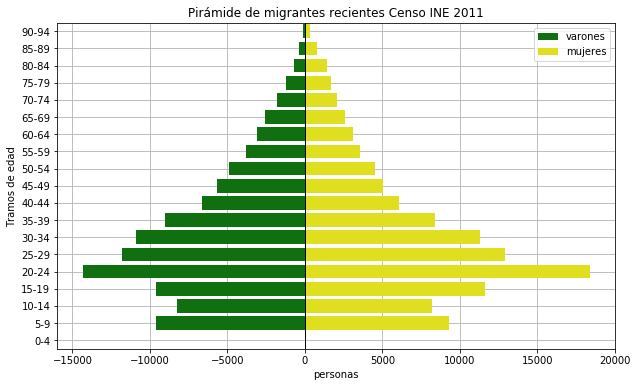

In [8]:
# pirámides de población

# cuatro ejes
fig, ax = plt.subplots(1, figsize= ( 10, 6 ), sharex= True, sharey='row')

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['green', 'yellow']
label=['sexo', 'sasa']

for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='personas', y='tramo', data=migrantes_group.loc[migrantes_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax)

# títulos
ax.set_title('Pirámide de migrantes recientes Censo INE 2011')

# ejes al fondo
ax.set_axisbelow(True)

# etiquetas de ejes
ax.set_ylabel("Tramos de edad")

# activa grilla de fondo
ax.grid(True)

# eje Y al medio
ax.axvline(linewidth=1, color='black')

# chirimbolos
plt.legend(loc='upper right')
plt.show()

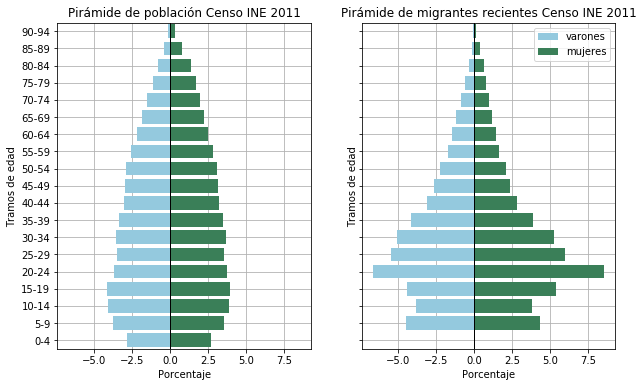

In [9]:
# pirámides de población

# cuatro ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= ( 10, 6 ), sharex= True, sharey='row')

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

for c, group in zip(colors, censo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo', data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax1)

for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo', data=migrantes_group.loc[migrantes_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax2)

ax1.set_title('Pirámide de población Censo INE 2011')
ax2.set_title('Pirámide de migrantes recientes Censo INE 2011')

for i in [ax1, ax2]:
    i.set_axisbelow(True)
    i.set_ylabel("Tramos de edad")
    i.set_xlabel("Porcentaje")
    i.grid(True)
    i.axvline(linewidth=1, color='black')

# chirimbolos
plt.legend(loc='upper right')
plt.show()

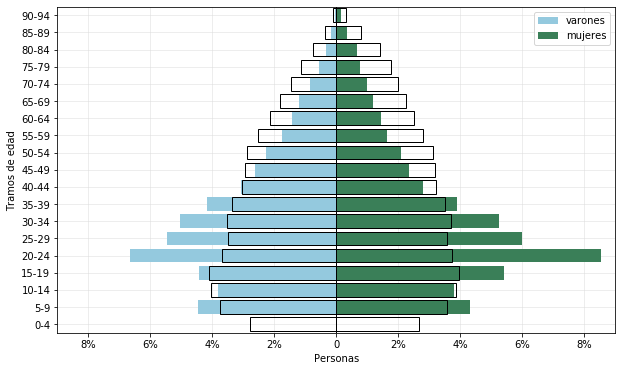

In [33]:
# pirámides de población
del ax

# cuatro ejes
fig, ax  = plt.subplots(1, figsize= ( 10, 6 ))

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']


for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=migrantes_group.loc[migrantes_group[group_col]==group, :],
                order = order_of_bars,
                color=c,
                label=group,
                ax=ax)

    sns.barplot(x='porc_pers', y='tramo',
                data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars,
                fill=False,
                linewidth = 1,
                edgecolor='black',
                ax=ax)

ax.set_axisbelow(True)
ax.grid(color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_ylabel("Tramos de edad")
ax.set_xlabel("Personas")
ax.axvline(linewidth=1, color='black')
ax.set_xlim([-9,9])
ax.set_xticklabels(['10%','8%','6%','4%','2%','0','2%','4%','6%','8%'])

# chirimbolos
plt.legend(loc='upper right')

plt.savefig('mapas_graficas/piramide_mig.pdf', bbox_inches='tight',
            metadata = metadatos_figs )

In [11]:
metadatos_figs = {'Author': '''Guillermo D'Angelo''', 'Title': 'Pirámide de población Censo INE 2011'}



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>